<h2>PROJET SANTE PUBLIQUE - Nettoyage des données<h2>

Nous importons des les packages dont nous avons besoin. A noter l'utilisation du package missingno permettant la visualisation des données manquantes

**Approche générale:**

Nous allons construiure une application de 'Health tracking' qui propose de scanner les aliments quotidiens qu'un utilisateur consomme quotidiennement. Notre application va donner une note à chacun des aliments. Ensuite, à la fin de la journée, l'utilisateur recevra une note concernant globale pour la journée, concernant sa nutrition. 

Nous allons faire ici l'étape de nettoyage des données. 

Ayant identifié les features cohérents avec notre application, nous avons identifiés les colonnes utiles de notre csv, et allons extraire ces colonnes. Notre travail de nettoyage se fera à partir de cette extraction.

In [1]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'

Nous changons de working directory pour simplifier import et export

Nous lancons la lecture de notre fichier via Pandas. A noter que nous allons extraire directement les features qui nous interessent, 'used_features' ci-dessous. Cela aura l'avantage aussi d'être moins consommateur en mémoire, donc moins de temps de calcul.

Les données initiales sont sépararés par une tabulation.

In [2]:
filepath = '/Users/efkanturedi/Corteze/openfoodfacts.csv'
used_features = ['product_name','brands','code','pnns_groups_1','nutriscore_grade','energy-kcal_100g','proteins_100g','carbohydrates_100g','sugars_100g','fat_100g','saturated-fat_100g','fiber_100g','sodium_100g','nutrition-score-fr_100g']
data = pd.read_csv(filepath, sep='\t', usecols=used_features)

/Users/efkanturedi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.options.display.float_format = "{:.1f}".format

In [4]:
data.shape

(1811863, 14)

In [5]:
data.describe()

energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
count         1385541.0 1430461.0           1387040.0           1429997.0   
mean          6338965.5      14.7                12.4                28.9   
std        7386271619.7     859.6              8491.0               647.8   
min                 0.0       0.0                 0.0                -1.0   
25%               101.0       0.8                 0.1                 3.5   
50%               262.0       7.0                 1.8                15.1   
75%               400.0      21.4                 7.1                53.0   
max     8693855001005.0  999999.0           9999999.0            762939.0   

       sugars_100g  fiber_100g  proteins_100g  sodium_100g  \
count    1413032.0    473190.0      1431514.0    1374215.0   
mean          14.0         5.1            8.8          1.2   
std          841.5      1453.7          146.2        345.6   
min           -1.0       -20.0         -500.0          0.0   
25%            0.6         0.0            1.3          0.0   
50%            3.6         1.6            6.0          0.2   
75%           18.0         3.6           12.3          0.6   
max       999999.0    999999.0       173000.0     399999.6   

       nutrition-score-fr_100g  
count                 671396.0  
mean                       9.2  
std                        8.9  
min                      -15.0  
25%                        2.0  
50%                       10.0  
75%                       16.0  
max                       40.0

In [6]:
data.head()

code                  product_name         brands  \
0       0000000000017              Vitória crackers            NaN   
1       0000000000031                         Cacao            NaN   
2  000000000003327986     Filetes de pollo empanado            NaN   
3  000000000004622327  Hamburguesas de ternera 100%            NaN   
4       0000000000100   moutarde au moût de raisin   courte paille   

  nutriscore_grade   pnns_groups_1  energy-kcal_100g  fat_100g  \
0              NaN         unknown             375.0       7.0   
1              NaN         unknown               NaN       NaN   
2              NaN         unknown               NaN       NaN   
3              NaN         unknown             874.9      15.1   
4                d  Fat and sauces               NaN       8.2   

   saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                 3.1                70.1         15.0         NaN   
1                 NaN                 NaN          NaN         NaN   
2                 NaN                 NaN          NaN         NaN   
3                 6.1                 2.6          1.0         NaN   
4                 2.2                29.0         22.0         0.0   

   proteins_100g  sodium_100g  nutrition-score-fr_100g  
0            7.8          0.6                      NaN  
1            NaN          NaN                      NaN  
2            NaN          NaN                      NaN  
3           15.7          0.8                      NaN  
4            5.1          1.8                     18.0

Nous voyons ici que notre jeu de données filtré contient beaucoup de NaN, soulignant un travail de nettoyage d'abord nécessaire de ce point de vue.

Dans le graphique ci-dessous, nous visualisons la complétude de nos features, et remarquons ainsi qu'ils sont plutôt non-NaN, excepté quatres features: additives_n, nutriscore_grade, fibre_100g, nutriscore-fr_100g

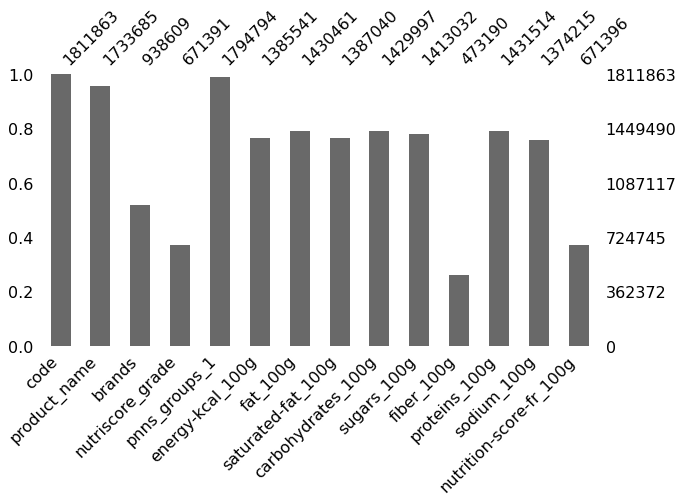

In [7]:
msno.bar(data, figsize=(10,5));

Nous créons une copie de notre jeu de données pour ne pas altérer le jeu initial

In [8]:
data_copy=data.copy(deep=True)

Nous savons que certaines features de notre base de données ont des caractérisques particulières. Beaucoup sont des valeurs comprises entre 0 et 100. Nous donnons le nom de "non_negative_capped_data" à ces features. Nous en profitons pour discuter les données numériques de manière générale

In [9]:
non_negative_capped_data = ['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g']
numeric_data = ['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','nutrition-score-fr_100g']

Ci-dessous nous traitons les valeurs abérrantes de la facon suivante: 
- si un point de "non_negative_capped_data" est négatif, nous méttons sa valeur à 0 (valeur minimale légale)
- si un point de "non_negative_capped_data" est supérieur à 100, nous méttons sa valeur à 100 (valeur maximale légale)
- pour energy-kcal, nous limitons la valeur maximale à 3000kcal

In [10]:
for col in non_negative_capped_data:
    data_copy[col][data_copy[col] < 0] = 0
    data_copy[col][data_copy[col] > 100] = 100
data_copy['energy-kcal_100g'][data_copy['energy-kcal_100g'] > 1500] = 1500

In [11]:
data_copy[['sugars_100g','fiber_100g','proteins_100g','sodium_100g']].describe()

sugars_100g  fiber_100g  proteins_100g  sodium_100g
count    1413032.0    473190.0      1431514.0    1374215.0
mean          13.3         3.0            8.6          0.6
std           19.6         5.0            9.8          2.9
min            0.0         0.0            0.0          0.0
25%            0.6         0.0            1.3          0.0
50%            3.6         1.6            6.0          0.2
75%           18.0         3.6           12.3          0.6
max          100.0       100.0          100.0        100.0

In [12]:
data_copy.shape

(1811863, 14)

In [13]:
data_copy.head()

code                  product_name         brands  \
0       0000000000017              Vitória crackers            NaN   
1       0000000000031                         Cacao            NaN   
2  000000000003327986     Filetes de pollo empanado            NaN   
3  000000000004622327  Hamburguesas de ternera 100%            NaN   
4       0000000000100   moutarde au moût de raisin   courte paille   

  nutriscore_grade   pnns_groups_1  energy-kcal_100g  fat_100g  \
0              NaN         unknown             375.0       7.0   
1              NaN         unknown               NaN       NaN   
2              NaN         unknown               NaN       NaN   
3              NaN         unknown             874.9      15.1   
4                d  Fat and sauces               NaN       8.2   

   saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                 3.1                70.1         15.0         NaN   
1                 NaN                 NaN          NaN         NaN   
2                 NaN                 NaN          NaN         NaN   
3                 6.1                 2.6          1.0         NaN   
4                 2.2                29.0         22.0         0.0   

   proteins_100g  sodium_100g  nutrition-score-fr_100g  
0            7.8          0.6                      NaN  
1            NaN          NaN                      NaN  
2            NaN          NaN                      NaN  
3           15.7          0.8                      NaN  
4            5.1          1.8                     18.0

Nous pouvons maintenant enlever les lignes de faible valeur ajoutée: ce sont les lignes dont les valeurs sont uniquement des NaNs.

In [14]:
new_data = data_copy.dropna(how='all',subset=numeric_data)
new_data = new_data.reset_index(drop=True)

In [15]:
new_data.tail()

code                      product_name              brands  \
1469657  9999999175305  Erdbeerkuchen 1019g tiefgefroren  Coppenrath & Wiese   
1469658       99999995             Steak haché pur boeuf                 NaN   
1469659     9999999901                               Scs                 NaN   
1469660  9999999990397                              Fati                 NaN   
1469661  9999999999994         Light & Free SKYR A BOIRE                 NaN   

        nutriscore_grade   pnns_groups_1  energy-kcal_100g  fat_100g  \
1469657                d   Sugary snacks               NaN       7.6   
1469658                a  Fish Meat Eggs             131.0       5.0   
1469659              NaN         unknown             100.0      12.0   
1469660              NaN         unknown              24.0       0.3   
1469661              NaN         unknown               0.0       0.2   

         saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
1469657                 4.8                35.0         24.0         NaN   
1469658                 2.3                 0.0          0.0         NaN   
1469659                 1.0                 2.0          1.0         NaN   
1469660                 0.0                 2.4          0.6         NaN   
1469661                 0.1                 8.0          7.8         NaN   

         proteins_100g  sodium_100g  nutrition-score-fr_100g  
1469657            2.6          0.1                     12.0  
1469658           21.5          0.1                     -2.0  
1469659            1.0          0.4                      NaN  
1469660            1.6          0.3                      NaN  
1469661            5.5          0.1                      NaN

In [16]:
new_data.shape

(1469662, 14)

In [17]:
range(len(new_data.index))

range(0, 1469662)

In [18]:
ind = []
for value in range(len(new_data.index)):
   if new_data['product_name'].loc[value] == 'Eau':
      ind.append(value) 
new_data.loc[ind].head(20)

code product_name      brands nutriscore_grade pnns_groups_1  \
138100  0054881013390          Eau         NaN              NaN       unknown   
141460    57379105010          Eau         NaN                a     Beverages   
159814    69000061015          Eau         NaN              NaN       unknown   
311191   671785301004          Eau        Eska                b       unknown   
351796   766200155000          Eau         NaN              NaN       unknown   
422111       11940016          Eau     Melliti                a     Beverages   
423825  1392013061253          Eau         NaN              NaN       unknown   
538507  2901102004225          Eau         NaN              NaN       unknown   
555222       30400108          Eau  Courmayeur                a     Beverages   
558637  3057640262548          Eau      volvic                b     Beverages   
560972  3068320113777          Eau       Evian                a     Beverages   
561029  3068320119267          Eau       Evian                a     Beverages   
561032  3068320119489          Eau       Evian              NaN     Beverages   
561047  3068320121550          Eau      Danone              NaN       unknown   
561066  3068320124377          Eau       Evian                a     Beverages   
561087  3068320731919          Eau       Evian                b       unknown   
561094  3068394258442          Eau         NaN              NaN       unknown   
570996  3119070444342          Eau         NaN                b     Beverages   
582136  3179730117887          Eau         NaN                b     Beverages   
582187  3179750060019          Eau         NaN              NaN       unknown   

        energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
138100               0.0       0.0                 0.0                 0.0   
141460               0.0       0.0                 NaN                 NaN   
159814               0.0       0.0                 0.0                 0.0   
311191               0.0       0.0                 0.0                 0.0   
351796               0.0       0.0                 0.0                 0.0   
422111               NaN       NaN                 NaN                 NaN   
423825               0.0       0.0                 0.0                 0.0   
538507              23.0       0.0                 0.0                 2.7   
555222               NaN       NaN                 NaN                 NaN   
558637               0.0       0.0                 0.0                 0.0   
560972               0.0       0.0                 0.0                 0.0   
561029               0.0       0.0                 0.0                 0.0   
561032               0.0       0.0                 0.0                 0.0   
561047               0.0       0.0                 0.0                 0.0   
561066               NaN       NaN                 NaN                 NaN   
561087               0.0       0.0                 0.0                 0.0   
561094               0.0       0.0                 0.0                 0.0   
570996               0.0       0.0                 0.0                 0.0   
582136               0.0       0.0                 0.0                 0.0   
582187               0.0       NaN                 NaN                 NaN   

        sugars_100g  fiber_100g  proteins_100g  sodium_100g  \
138100          0.0         NaN            0.0          0.0   
141460          NaN         NaN            NaN          0.0   
159814          0.0         NaN            0.0          0.0   
311191          0.0         0.0            0.0          0.0   
351796          0.0         NaN            0.0          0.0   
422111          NaN         NaN            NaN          0.0   
423825          0.0         NaN            0.0          0.0   
538507          0.0         NaN           35.0          0.0   
555222          NaN         NaN            NaN          NaN   
558637          0.0         NaN            0.0

In [19]:
new_data = new_data.reset_index(drop=True)

Nous allons procéder à la préparation de l'utilisation de KNNImputer. Nous copions les données numériques dans un dataframe, et copions les valeurs numériques dans full_num

In [20]:
secondary_data=new_data[:][['code','product_name','pnns_groups_1','nutriscore_grade']]
secondary_data = secondary_data.reset_index(drop=True)

In [21]:
full_num = new_data[numeric_data]

In [22]:
random_sample_full_num=full_num.sample(20000) 
random_sample_full_num

energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
163903              548.0      28.6                19.1                64.3   
475125              249.0      17.0                 6.2                 5.9   
1359448             302.0       0.1                 0.1                75.1   
1284572             293.0      21.0                13.8                 0.0   
60736               571.0      46.4                 5.4                21.4   
...                   ...       ...                 ...                 ...   
681650                NaN       NaN                 NaN                 NaN   
211156              114.0       4.4                 0.4                14.0   
1245612             380.0       0.2                 0.1                88.2   
417494              167.0       0.0                 0.0                40.0   
1042856             559.0      34.0                20.0                57.0   

         sugars_100g  fiber_100g  proteins_100g  sodium_100g  \
163903          61.9         0.0            4.8          0.2   
475125           4.7         NaN           19.0          0.5   
1359448         11.3         NaN            0.4          0.0   
1284572          0.0         NaN           25.0          0.6   
60736            7.1         7.1           25.0          0.2   
...              ...         ...            ...          ...   
681650           NaN         NaN            NaN          0.0   
211156           0.9         1.8            5.3          0.5   
1245612          9.2         NaN            1.7          0.6   
417494          33.3         0.0            0.0          0.0   
1042856         45.0         1.6            4.7          0.2   

         nutrition-score-fr_100g  
163903                      27.0  
475125                       NaN  
1359448                      NaN  
1284572                      NaN  
60736                        9.0  
...                          ...  
681650                       NaN  
211156                       2.0  
1245612                      NaN  
417494                       9.0  
1042856                     25.0  

[20000 rows x 9 columns]

Nous avons fait le choix de fitter notre modèle sur 20,000 lignes choisis de manière aléatoire pour alléger le temps de calcul dans le processus de transformation. Ainsi, nous obtenons data_Knned après 2h30 de temps de calcul

In [23]:
imputer = KNNImputer(n_neighbors=3)
imputer.fit(random_sample_full_num)

KNNImputer(n_neighbors=3)

In [24]:
data_Knned = imputer.transform(full_num)

In [25]:
df = pd.DataFrame(data_Knned,columns = numeric_data)

In [26]:
df.head()

energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
0             375.0       7.0                 3.1                70.1   
1             874.9      15.1                 6.1                 2.6   
2             171.0       8.2                 2.2                29.0   
3              21.0       0.0                 0.0                 4.8   
4              60.0       3.0                 1.0                10.0   

   sugars_100g  fiber_100g  proteins_100g  sodium_100g  \
0         15.0         6.9            7.8          0.6   
1          1.0         0.0           15.7          0.8   
2         22.0         0.0            5.1          1.8   
3          0.4         1.8            0.2          0.8   
4          3.0         1.6            2.0          0.5   

   nutrition-score-fr_100g  
0                      0.0  
1                      3.7  
2                     18.0  
3                     -3.0  
4                      0.0

Nous fusionnons les valeurs numériques aves le dataframe secondary_data

In [27]:
final = pd.concat([secondary_data, df], axis=1)

In [28]:
final

code                      product_name   pnns_groups_1  \
0             0000000000017                  Vitória crackers         unknown   
1        000000000004622327      Hamburguesas de ternera 100%         unknown   
2             0000000000100       moutarde au moût de raisin   Fat and sauces   
3             0000000000123             Sauce Sweety chili 0%         unknown   
4             0000000000178                         Mini coco         unknown   
...                     ...                               ...             ...   
1469657       9999999175305  Erdbeerkuchen 1019g tiefgefroren   Sugary snacks   
1469658            99999995             Steak haché pur boeuf  Fish Meat Eggs   
1469659          9999999901                               Scs         unknown   
1469660       9999999990397                              Fati         unknown   
1469661       9999999999994         Light & Free SKYR A BOIRE         unknown   

        nutriscore_grade  energy-kcal_100g  fat_100g  saturated-fat_100g  \
0                    NaN             375.0       7.0                 3.1   
1                    NaN             874.9      15.1                 6.1   
2                      d             171.0       8.2                 2.2   
3                    NaN              21.0       0.0                 0.0   
4                    NaN              60.0       3.0                 1.0   
...                  ...               ...       ...                 ...   
1469657                d              46.7       7.6                 4.8   
1469658                a             131.0       5.0                 2.3   
1469659              NaN             100.0      12.0                 1.0   
1469660              NaN              24.0       0.3                 0.0   
1469661              NaN               0.0       0.2                 0.1   

         carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  \
0                      70.1         15.0         6.9            7.8   
1                       2.6          1.0         0.0           15.7   
2                      29.0         22.0         0.0            5.1   
3                       4.8          0.4         1.8            0.2   
4                      10.0          3.0         1.6            2.0   
...                     ...          ...         ...            ...   
1469657                35.0         24.0         2.0            2.6   
1469658                 0.0          0.0         0.0           21.5   
1469659                 2.0          1.0         3.1            1.0   
1469660                 2.4          0.6         2.6            1.6   
1469661                 8.0          7.8         0.5            5.5   

         sodium_100g  nutrition-score-fr_100g  
0                0.6                      0.0  
1                0.8                      3.7  
2                1.8                     18.0  
3                0.8                     -3.0  
4                0.5                      0.0  
...              ...                      ...  
1469657          0.1                     12.0  
1469658          0.1                     -2.0  
1469659          0.4                      0.0  
1469660          0.3                     -0.7  
1469661          0.1                      0.0  

[1469662 rows x 13 columns]

In [29]:
def grader_food(x):
        if x<=-1:
            return 'a'
        elif (x>-1)&(x<=2):
            return 'b'
        elif (x>2)&(x<=10):
            return 'c'
        elif (x>10)&(x<=18):
            return 'd'
        else:
            return 'e'

def grader_beverages(x):
        if (x<=0):
            return 'a'
        elif (x>0)&(x<=1):
            return 'b'
        elif (x>1)&(x<=5):
            return 'c'
        elif (x>5)&(x<=9):
            return 'd'
        else:
            return 'e'

In [30]:
for ind in range(len(final.index)):
    if final['nutriscore_grade'].loc[ind] is np.nan:
        if final['pnns_groups_1'].loc[ind] == 'Beverages':
            final['nutriscore_grade'].loc[ind] = grader_beverages(final['nutrition-score-fr_100g'].loc[ind])
        else:
            final['nutriscore_grade'].loc[ind] = grader_food(final['nutrition-score-fr_100g'].loc[ind])

In [31]:
final

code                      product_name   pnns_groups_1  \
0             0000000000017                  Vitória crackers         unknown   
1        000000000004622327      Hamburguesas de ternera 100%         unknown   
2             0000000000100       moutarde au moût de raisin   Fat and sauces   
3             0000000000123             Sauce Sweety chili 0%         unknown   
4             0000000000178                         Mini coco         unknown   
...                     ...                               ...             ...   
1469657       9999999175305  Erdbeerkuchen 1019g tiefgefroren   Sugary snacks   
1469658            99999995             Steak haché pur boeuf  Fish Meat Eggs   
1469659          9999999901                               Scs         unknown   
1469660       9999999990397                              Fati         unknown   
1469661       9999999999994         Light & Free SKYR A BOIRE         unknown   

        nutriscore_grade  energy-kcal_100g  fat_100g  saturated-fat_100g  \
0                      b             375.0       7.0                 3.1   
1                      c             874.9      15.1                 6.1   
2                      d             171.0       8.2                 2.2   
3                      a              21.0       0.0                 0.0   
4                      b              60.0       3.0                 1.0   
...                  ...               ...       ...                 ...   
1469657                d              46.7       7.6                 4.8   
1469658                a             131.0       5.0                 2.3   
1469659                b             100.0      12.0                 1.0   
1469660                b              24.0       0.3                 0.0   
1469661                b               0.0       0.2                 0.1   

         carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  \
0                      70.1         15.0         6.9            7.8   
1                       2.6          1.0         0.0           15.7   
2                      29.0         22.0         0.0            5.1   
3                       4.8          0.4         1.8            0.2   
4                      10.0          3.0         1.6            2.0   
...                     ...          ...         ...            ...   
1469657                35.0         24.0         2.0            2.6   
1469658                 0.0          0.0         0.0           21.5   
1469659                 2.0          1.0         3.1            1.0   
1469660                 2.4          0.6         2.6            1.6   
1469661                 8.0          7.8         0.5            5.5   

         sodium_100g  nutrition-score-fr_100g  
0                0.6                      0.0  
1                0.8                      3.7  
2                1.8                     18.0  
3                0.8                     -3.0  
4                0.5                      0.0  
...              ...                      ...  
1469657          0.1                     12.0  
1469658          0.1                     -2.0  
1469659          0.4                      0.0  
1469660          0.3                     -0.7  
1469661          0.1                      0.0  

[1469662 rows x 13 columns]

In [32]:
final.to_csv('openfoodfacts_clean_prod_new.csv', index=False)